In [31]:
# обработка видоса с моноколесом

import numpy as np
import cv2
import matplotlib.pyplot as plt
import time

cv2.namedWindow("th")

cv2.namedWindow("frame", cv2.WINDOW_NORMAL)
# cv2.namedWindow("mask", cv2.WINDOW_NORMAL)
# cv2.namedWindow("opened", cv2.WINDOW_NORMAL)
# cv2.namedWindow("closed", cv2.WINDOW_NORMAL)
# cv2.namedWindow("eroded", cv2.WINDOW_NORMAL)
# cv2.namedWindow("dilated", cv2.WINDOW_NORMAL)

video_path = "unicycle.mp4"
# video_path = 0
cam = cv2.VideoCapture(video_path)

success, frame = cam.read()
if (success == False):
    assert(False)

background = np.zeros_like(frame)

cv2.createTrackbar("hb", "th", 255  , 255 , lambda i : i)
cv2.createTrackbar("lb", "th", 10   , 255 , lambda i : i)
cv2.createTrackbar("hg", "th", 255  , 255 , lambda i : i)
cv2.createTrackbar("lg", "th", 5    , 255 , lambda i : i)
cv2.createTrackbar("hr", "th", 255  , 255 , lambda i : i)
cv2.createTrackbar("lr", "th", 20   , 255 , lambda i : i)
cv2.createTrackbar("ha", "th", 50000, 100000, lambda i : i)
cv2.createTrackbar("la", "th", 11000, 50000, lambda i : i)

x_now = 0
t0 = time.time()
dt = 1.0

x_prev = x_now
t_prev = t0


while (True):
    success, frame = cam.read()
    
    if (success == False):
        cam.release()
        cam = cv2.VideoCapture(video_path)
        continue

    background = cv2.addWeighted(background, 0.6, frame, 0.4, 0) 
    diff = cv2.absdiff(background, frame)
        
    hsv = cv2.cvtColor(diff, cv2.COLOR_BGR2HSV)

    hb = cv2.getTrackbarPos("hb", "th")
    lb = cv2.getTrackbarPos("lb", "th")
    hg = cv2.getTrackbarPos("hg", "th")
    lg = cv2.getTrackbarPos("lg", "th")
    hr = cv2.getTrackbarPos("hr", "th")
    lr = cv2.getTrackbarPos("lr", "th")
    
    mask = cv2.inRange(hsv, (lb,lg,lr), (hb,hg,hr))

    kernel = np.ones((30,30), np.uint8)
    # eroded = cv2.morphologyEx(mask, cv2.MORPH_ERODE, kernel)
    # dilated = cv2.morphologyEx(mask, cv2.MORPH_DILATE, kernel)
    # opened = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    closed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    connectivity = 4
    output = cv2.connectedComponentsWithStats(closed, connectivity, cv2.CV_32S)
    num_labels = output[0]
    labels = output[1]
    stats = output[2]
    centroid = output[3]
    areas = []

    ha = cv2.getTrackbarPos("ha", "th")
    la = cv2.getTrackbarPos("la", "th")
    
    for i in range(num_labels):
        t = stats[i, cv2.CC_STAT_TOP   ]
        l = stats[i, cv2.CC_STAT_LEFT  ]
        w = stats[i, cv2.CC_STAT_WIDTH ]
        h = stats[i, cv2.CC_STAT_HEIGHT]
        a = stats[i, cv2.CC_STAT_AREA  ]
        
        if (a>la and a<ha and h/w>1.5):
            cv2.rectangle(frame, (l,t), (l+w,t+h), (123,34,234), 3)
            areas.append(a)
            
            x_now = l+w//2

            t_now = time.time() - t0
            dt = t_now - t_prev
            dx = x_now - x_prev

            x_prev = x_now
            t_prev = t_now
    
    cv2.putText(frame, "x = {}".format(x_now),(20,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (123,34,234), 1)
    # cv2.putText(frame, "v = {}".format(dx/dt),(20,60), cv2.FONT_HERSHEY_SIMPLEX, 1, (123,34,234), 1)

    cv2.imshow("frame", frame)
    # cv2.imshow("mask", mask)
    # cv2.imshow("opened", opened)
    # cv2.imshow("closed", closed)
    # cv2.imshow("eroded", eroded)
    # cv2.imshow("dilated", dilated)

    key = cv2.waitKey(30) & 0xFF
    
    if (key == ord('q')):
        break

cam.release()
cv2.destroyAllWindows()
cv2.waitKey(10)

-1

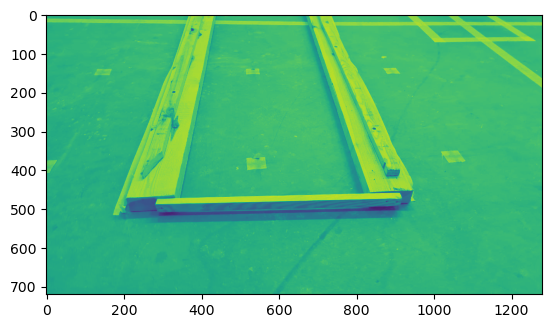

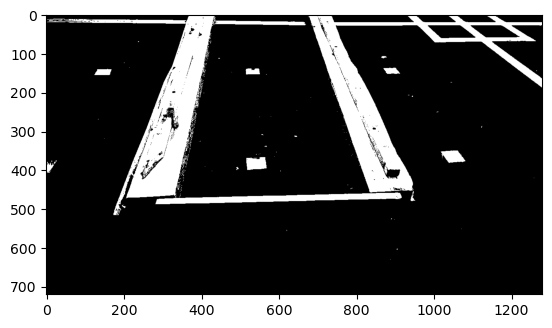

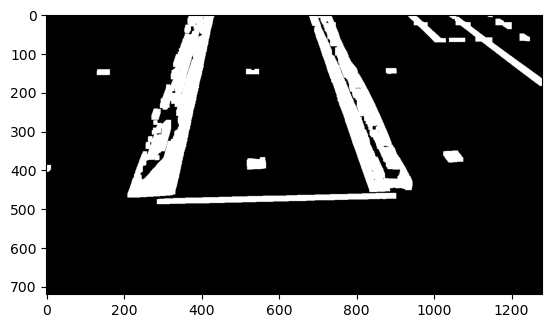

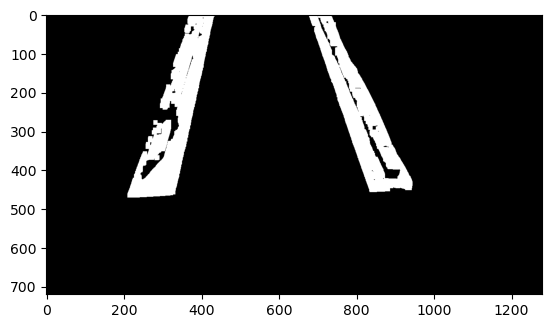

In [25]:
# Адаптивная бинаризация

import cv2
import copy
import matplotlib.pyplot as plt
import numpy as np

# cv2.namedWindow("th")
# cv2.namedWindow("img", cv2.WINDOW_NORMAL)
# cv2.namedWindow("hsv", cv2.WINDOW_NORMAL)
# cv2.namedWindow("mask", cv2.WINDOW_NORMAL)
# cv2.namedWindow("opened", cv2.WINDOW_NORMAL)

img = cv2.imread("./rails.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

fig, ax = plt.subplots()
fig.canvas.draw()

ret, otsu = cv2.threshold(img[:,:,0], 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

kernel = np.ones((11,11), np.uint8)
# eroded = cv2.morphologyEx(otsu, cv2.MORPH_ERODE, kernel)
# dilated = cv2.morphologyEx(otsu, cv2.MORPH_DILATE, kernel)
opened = cv2.morphologyEx(otsu, cv2.MORPH_OPEN, kernel)
# closed = cv2.morphologyEx(otsu, cv2.MORPH_CLOSE, kernel)

connectivity = 4
output = cv2.connectedComponentsWithStats(opened, connectivity, cv2.CV_32S)
num_labels = output[0]
labels = output[1]
stats = output[2]
centroid = output[3]
areas = []

filtered = np.zeros_like(opened)

for i in range(1,num_labels):
    t = stats[i, cv2.CC_STAT_TOP   ]
    l = stats[i, cv2.CC_STAT_LEFT  ]
    w = stats[i, cv2.CC_STAT_WIDTH ]
    h = stats[i, cv2.CC_STAT_HEIGHT]
    a = stats[i, cv2.CC_STAT_AREA  ]
        
    if (a > 10000):
        # cv2.rectangle(frame, (l,t), (l+w,t+h), (123,34,234), 3)
        # areas.append(a)
        filtered[np.where(labels == i)] = 255

plt.imshow(img[:,:,1])
plt.show()

# print(ret)
plt.imshow(otsu, cmap = 'gray')
plt.show()

plt.imshow(opened, cmap = 'gray')
plt.show()

plt.imshow(filtered, cmap = 'gray')
plt.show()


# mask = cv2.inRange(hsv, (155,0,0), (255,255,255))

# kernel = np.ones((40,40), np.uint8)
# opened = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

# cv2.imshow("img", img)
# cv2.imshow("hsv", hsv[:, :, 0])
# cv2.imshow("mask", mask)
# cv2.imshow("opened", opened)

# cv2.waitKey(0)
# cv2.destroyAllWindows()
# cv2.waitKey(10)